In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from PIL import Image # To convert numpy array to PIL Image for transforms
from transformers import ConvNextV2ForImageClassification, AutoImageProcessor
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import zipfile
from itertools import cycle

In [14]:
zip_path = 'dataset.zip'  
extract_to = 'dataset1/'  

# Create directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [15]:
root_dir = "dataset1/dataset"
second_dir = "dataset_zNorm/"
# Define the class names.
classes = ['no', 'sphere', 'vort']

In [17]:
# Function to count .npy files in each class folder for a given split.
def count_files(split):
    counts = {}
    split_dir = os.path.join(root_dir, split)
    for cls in classes:
        class_dir = os.path.join(split_dir, cls)
        file_list = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
        counts[cls] = len(file_list)
    return counts

# Count files in train and validation splits.
train_counts = count_files('train')
val_counts = count_files('val')

print("Training set file counts per class:", train_counts)
print("Validation set file counts per class:", val_counts)

Training set file counts per class: {'no': 10000, 'sphere': 10000, 'vort': 10000}
Validation set file counts per class: {'no': 2500, 'sphere': 2500, 'vort': 2500}


In [19]:
# Define input and output root directories.
input_root = "dataset1/dataset"         # Original dataset folder.
output_root = "dataset_zNorm"  # New folder to store z-normalized images.

# Define the splits and classes based on your dataset structure.
splits = ["train", "val"]
classes = ["no", "sphere", "vort"]

# Loop over each split and class.
for split in splits:
    for cls in classes:
        input_dir = os.path.join(input_root, split, cls)
        output_dir = os.path.join(output_root, split, cls)
        
        # Create output directory if it doesn't exist.
        os.makedirs(output_dir, exist_ok=True)
        
        # Process each .npy file in the input directory.
        file_list = [f for f in os.listdir(input_dir) if f.endswith('.npy')]
        for filename in file_list:
            input_file = os.path.join(input_dir, filename)
            output_file = os.path.join(output_dir, filename)
            
            # Load the image (expected shape: (1, 150, 150)).
            image = np.load(input_file)
            
            # Compute the mean and standard deviation.
            mu = np.mean(image)
            sigma = np.std(image)
            
            # Avoid division by zero.
            if sigma == 0:
                normalized = image - mu
            else:
                normalized = (image - mu) / sigma
            
            # Save the normalized image.
            np.save(output_file, normalized)
        
        print(f"Processed {input_dir} -> {output_dir}")

print("Z-normalization complete. Normalized dataset stored in:", output_root)


Processed dataset1/dataset/train/no -> dataset_zNorm/train/no
Processed dataset1/dataset/train/sphere -> dataset_zNorm/train/sphere
Processed dataset1/dataset/train/vort -> dataset_zNorm/train/vort
Processed dataset1/dataset/val/no -> dataset_zNorm/val/no
Processed dataset1/dataset/val/sphere -> dataset_zNorm/val/sphere
Processed dataset1/dataset/val/vort -> dataset_zNorm/val/vort
Z-normalization complete. Normalized dataset stored in: dataset_zNorm


In [20]:
# Function to load samples from a given split and class using different selection modes.
def load_samples(split, cls, num_samples=10, mode="random"):
    """
    Loads samples from a given split and class.
    
    Args:
        split (str): "train" or "val"
        cls (str): The class name, e.g. "no", "sphere", or "vort"
        num_samples (int): Number of samples to select.
        mode (str): One of "random", "first", or "last" to determine which samples to load.
    
    Returns:
        List of images loaded as numpy arrays.
    """
    class_dir = os.path.join(root_dir, split, cls)
    files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    if len(files) == 0:
        return []
    # Sort files to have a consistent order for first/last.
    files.sort()
    
    if mode == "random":
        selected_files = random.sample(files, min(num_samples, len(files)))
    elif mode == "first":
        selected_files = files[:num_samples]
    elif mode == "last":
        selected_files = files[-num_samples:]
    else:
        raise ValueError("Mode must be 'random', 'first', or 'last'")
    
    images = []
    for fname in selected_files:
        file_path = os.path.join(class_dir, fname)
        img = np.load(file_path)
        images.append(img)
    return images

# Function to plot samples for a given split and mode.
def plot_samples(split, mode="random", num_samples=10):
    """
    Plots num_samples images per class for the specified split and selection mode.
    
    Args:
        split (str): "train" or "val".
        mode (str): "random", "first", or "last".
        num_samples (int): Number of images to display per class.
    """
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes):
        imgs = load_samples(split, cls, num_samples=num_samples, mode=mode)
        for j, img in enumerate(imgs):
            # If image shape is (1, H, W), squeeze out the channel dimension.
            if img.ndim == 3 and img.shape[0] == 1:
                img_plot = img.squeeze(0)
            else:
                img_plot = img
            ax = plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            ax.imshow(img_plot, cmap='gray')
            if j == 0:
                ax.set_ylabel(cls, fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(f"{split.capitalize()} Split - Mode: {mode.capitalize()} - {num_samples} Samples per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example calls:
# Plot 10 random samples per class from the training split.
plot_samples('train', mode="random", num_samples=10)

# Plot 10 first samples per class from the training split.
plot_samples('train', mode="first", num_samples=10)

# Plot 10 last samples per class from the validation split.
plot_samples('val', mode="last", num_samples=10)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset1/dataset/train/no'

<Figure size 1500x500 with 0 Axes>

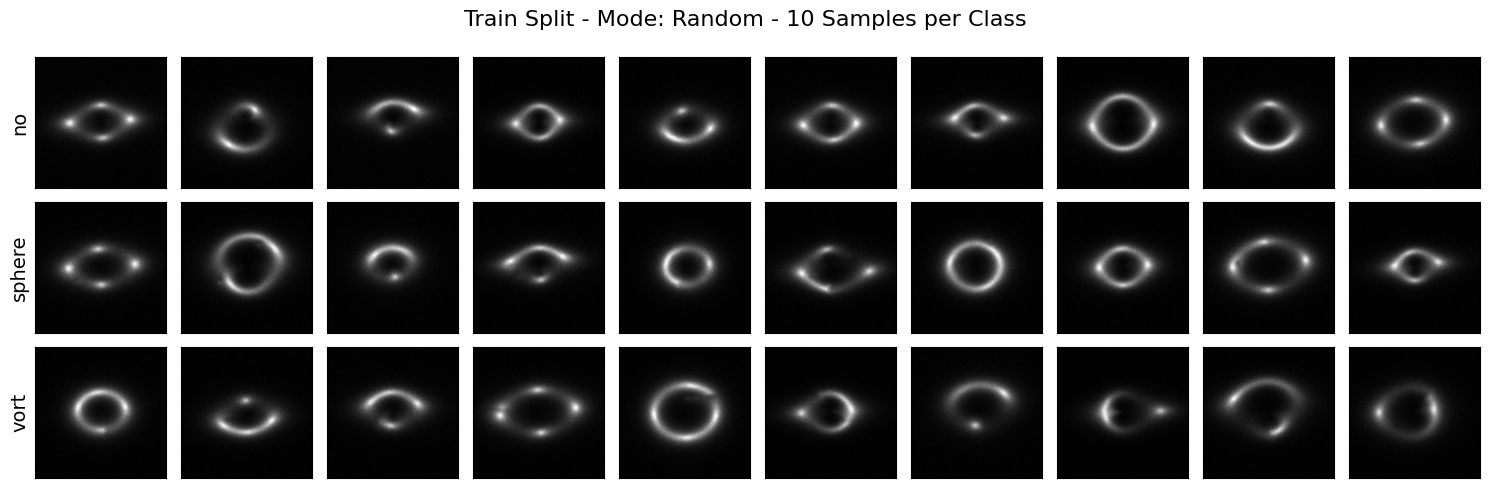

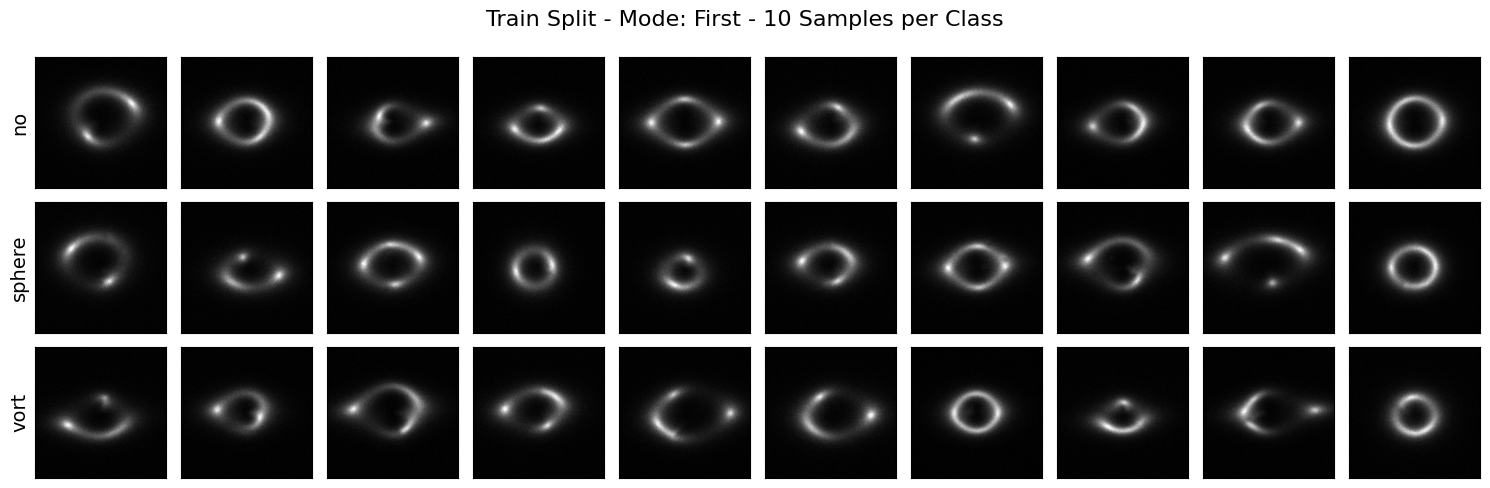

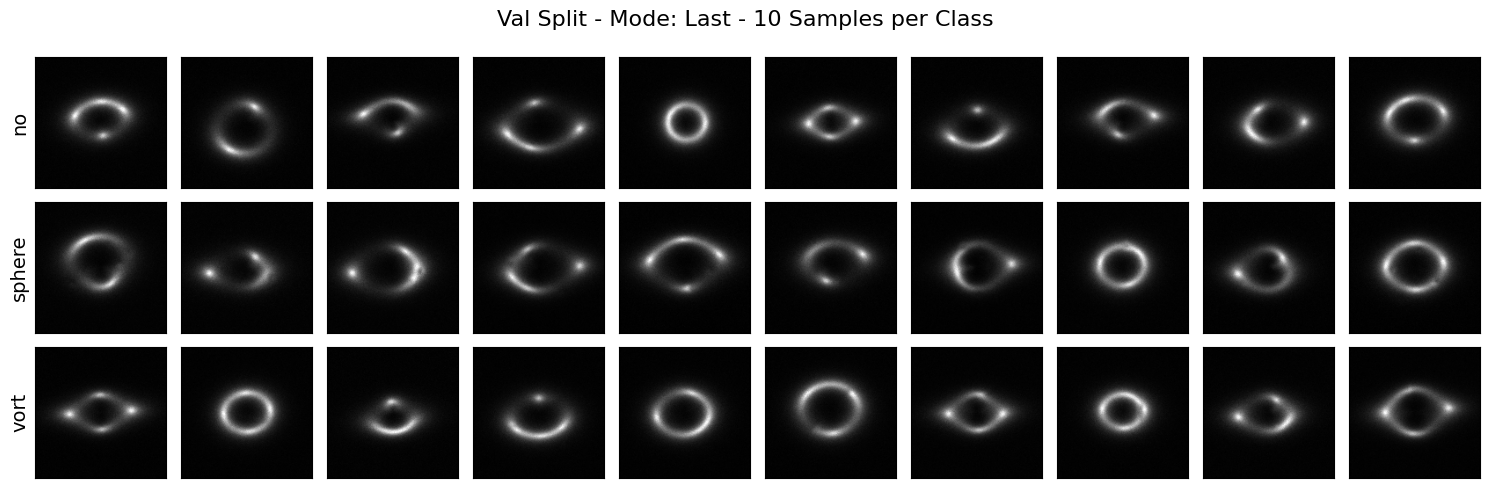

In [21]:
# Function to load samples from a given split and class using different selection modes.
def load_samples(split, cls, num_samples=10, mode="random"):
    """
    Loads samples from a given split and class.
    
    Args:
        split (str): "train" or "val"
        cls (str): The class name, e.g. "no", "sphere", or "vort"
        num_samples (int): Number of samples to select.
        mode (str): One of "random", "first", or "last" to determine which samples to load.
    
    Returns:
        List of images loaded as numpy arrays.
    """
    class_dir = os.path.join(second_dir, split, cls)
    files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    if len(files) == 0:
        return []
    # Sort files to have a consistent order for first/last.
    files.sort()
    
    if mode == "random":
        selected_files = random.sample(files, min(num_samples, len(files)))
    elif mode == "first":
        selected_files = files[:num_samples]
    elif mode == "last":
        selected_files = files[-num_samples:]
    else:
        raise ValueError("Mode must be 'random', 'first', or 'last'")
    
    images = []
    for fname in selected_files:
        file_path = os.path.join(class_dir, fname)
        img = np.load(file_path)
        images.append(img)
    return images

# Function to plot samples for a given split and mode.
def plot_samples(split, mode="random", num_samples=10):
    """
    Plots num_samples images per class for the specified split and selection mode.
    
    Args:
        split (str): "train" or "val".
        mode (str): "random", "first", or "last".
        num_samples (int): Number of images to display per class.
    """
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes):
        imgs = load_samples(split, cls, num_samples=num_samples, mode=mode)
        for j, img in enumerate(imgs):
            # If image shape is (1, H, W), squeeze out the channel dimension.
            if img.ndim == 3 and img.shape[0] == 1:
                img_plot = img.squeeze(0)
            else:
                img_plot = img
            ax = plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            ax.imshow(img_plot, cmap='gray')
            if j == 0:
                ax.set_ylabel(cls, fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(f"{split.capitalize()} Split - Mode: {mode.capitalize()} - {num_samples} Samples per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example calls:
# Plot 10 random samples per class from the training split.
plot_samples('train', mode="random", num_samples=10)

# Plot 10 first samples per class from the training split.
plot_samples('train', mode="first", num_samples=10)

# Plot 10 last samples per class from the validation split.
plot_samples('val', mode="last", num_samples=10)

In [22]:
def check_npy_dimensions(root_dir, split, classes=['no', 'sphere', 'vort'], sample_limit=None):
    """
    Checks the dimensions of .npy files in a given dataset split.
    
    Args:
        root_dir (str): Root directory of the dataset (e.g., "dataset").
        split (str): Split name ("train" or "val").
        classes (list): List of class folder names.
        sample_limit (int, optional): If set, only process up to this number of files per class.
        
    Returns:
        dict: A dictionary mapping each class to a dictionary of shape counts.
    """
    shape_counts = {}
    
    for cls in classes:
        class_dir = os.path.join(root_dir, split, cls)
        shape_counts[cls] = {}
        files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
        if sample_limit is not None:
            files = files[:sample_limit]
            
        for fname in files:
            file_path = os.path.join(class_dir, fname)
            try:
                img = np.load(file_path)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue
                
            shape = img.shape
            if shape in shape_counts[cls]:
                shape_counts[cls][shape] += 1
            else:
                shape_counts[cls][shape] = 1
                
        print(f"Processed {len(files)} files in {class_dir}")
    return shape_counts


train_shapes = check_npy_dimensions(root_dir, split="train", sample_limit=100)  
val_shapes   = check_npy_dimensions(root_dir, split="val", sample_limit=100)

print("Train split dimension summary:")
for cls, counts in train_shapes.items():
    print(f"Class {cls}: {counts}")

print("\nValidation split dimension summary:")
for cls, counts in val_shapes.items():
    print(f"Class {cls}: {counts}")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset1/dataset/train/no'

In [23]:
train_shapes_z = check_npy_dimensions(second_dir, split="train", sample_limit=100)  
val_shapes_z   = check_npy_dimensions(second_dir, split="val", sample_limit=100)

print("Train split dimension summary:")
for cls, counts in train_shapes_z.items():
    print(f"Class {cls}: {counts}")

print("\nValidation split dimension summary:")
for cls, counts in val_shapes_z.items():
    print(f"Class {cls}: {counts}")

Processed 100 files in dataset_zNorm/train/no
Processed 100 files in dataset_zNorm/train/sphere
Processed 100 files in dataset_zNorm/train/vort
Processed 100 files in dataset_zNorm/val/no
Processed 100 files in dataset_zNorm/val/sphere
Processed 100 files in dataset_zNorm/val/vort
Train split dimension summary:
Class no: {(1, 150, 150): 100}
Class sphere: {(1, 150, 150): 100}
Class vort: {(1, 150, 150): 100}

Validation split dimension summary:
Class no: {(1, 150, 150): 100}
Class sphere: {(1, 150, 150): 100}
Class vort: {(1, 150, 150): 100}


In [24]:
# Define the source normalized dataset and output folder.
normalized_root = "dataset_zNorm"   # This folder contains the normalized "train" and "val" subfolders.
output_root = "dataset_split"         # New folder to store train, val, and test splits.

# Define our splits and class names.
splits = ["train", "val", "test"]
classes = ["no", "sphere", "vort"]

# Create output directories for each split and each class.
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_root, split, cls), exist_ok=True)

# --- Copy the training set as is from the normalized dataset ---
for cls in classes:
    src_train_dir = os.path.join(normalized_root, "train", cls)
    dst_train_dir = os.path.join(output_root, "train", cls)
    files = [f for f in os.listdir(src_train_dir) if f.endswith('.npy')]
    for f in files:
        shutil.copy(os.path.join(src_train_dir, f), os.path.join(dst_train_dir, f))
    print(f"Copied {len(files)} files for class '{cls}' to training set.")

# --- Split the normalized validation set into new validation and test sets ---
for cls in classes:
    src_val_dir = os.path.join(normalized_root, "val", cls)
    dst_val_dir = os.path.join(output_root, "val", cls)
    dst_test_dir = os.path.join(output_root, "test", cls)
    
    # List and sort files for reproducibility.
    files = [f for f in os.listdir(src_val_dir) if f.endswith('.npy')]
    files.sort()
    
    n = len(files)  # For your dataset, n should be 2500 per class.
    print(f"Found {n} files in {src_val_dir}")
    half = n // 2  # This gives ~1250 files per half.
    
    val_files = files[:half]
    test_files = files[half:]
    
    for f in val_files:
        shutil.copy(os.path.join(src_val_dir, f), os.path.join(dst_val_dir, f))
    for f in test_files:
        shutil.copy(os.path.join(src_val_dir, f), os.path.join(dst_test_dir, f))
    
    print(f"For class '{cls}': {len(val_files)} files copied to new validation, {len(test_files)} files copied to test.")

print("Dataset splitting complete. Training remains unchanged; the normalized validation set is split equally into new validation and test sets.")

Copied 10000 files for class 'no' to training set.
Copied 10000 files for class 'sphere' to training set.
Copied 10000 files for class 'vort' to training set.
Found 2500 files in dataset_zNorm/val/no
For class 'no': 1250 files copied to new validation, 1250 files copied to test.
Found 2500 files in dataset_zNorm/val/sphere
For class 'sphere': 1250 files copied to new validation, 1250 files copied to test.
Found 2500 files in dataset_zNorm/val/vort
For class 'vort': 1250 files copied to new validation, 1250 files copied to test.
Dataset splitting complete. Training remains unchanged; the normalized validation set is split equally into new validation and test sets.


In [25]:
# Set the path to the main directory you want to check
output_root = "dataset_split"

# List the splits (subdirectories) you expect inside output_root
splits_to_check = ["train", "val", "test"]

# List the classes (sub-subdirectories) you expect inside each split
classes_to_check = ["no", "sphere", "vort"]

# Specify the file extension to count (e.g., ".npy", ".jpg", ".txt")
# Set to None or "" to count ALL files regardless of extension.
file_extension_to_count = ".npy"

# --- End of Configuration ---

print(f"Checking file counts in directory: '{output_root}'")
if file_extension_to_count:
    print(f"Counting only files ending with: '{file_extension_to_count}'")
else:
    print("Counting all files.")
print("-" * 40)

grand_total_files = 0

# Loop through each specified split directory
for split in splits_to_check:
    print(f"--- Split: {split} ---")
    split_path = os.path.join(output_root, split)
    total_files_in_split = 0

    # Check if the split directory itself exists
    if not os.path.isdir(split_path):
        print(f"  Split directory '{split_path}' not found.")
        print("-" * 20)
        continue # Skip to the next split

    # Loop through each specified class directory within the split
    for cls in classes_to_check:
        class_dir = os.path.join(split_path, cls)
        count = 0

        # Check if the class directory exists
        if os.path.isdir(class_dir):
            try:
                # List all entries (files and directories) in the class directory
                entries = os.listdir(class_dir)

                # Filter the list to include only files
                # Optionally, further filter by the specified file extension
                if file_extension_to_count:
                    files = [f for f in entries if
                             os.path.isfile(os.path.join(class_dir, f)) and f.endswith(file_extension_to_count)]
                else:
                    # Count all files if no extension is specified
                    files = [f for f in entries if
                             os.path.isfile(os.path.join(class_dir, f))]

                count = len(files)
                print(f"  Class '{cls}': {count} files")

            except OSError as e:
                # Handle potential permission errors etc.
                print(f"  Class '{cls}': Error accessing - {e}")
        else:
            print(f"  Class '{cls}': Directory not found")

        total_files_in_split += count

    print(f"Total for split '{split}': {total_files_in_split} files")
    grand_total_files += total_files_in_split
    print("-" * 20)

print("=" * 40)
print(f"Grand total files counted: {grand_total_files}")
print("=" * 40)

Checking file counts in directory: 'dataset_split'
Counting only files ending with: '.npy'
----------------------------------------
--- Split: train ---
  Class 'no': 10000 files
  Class 'sphere': 10000 files
  Class 'vort': 10000 files
Total for split 'train': 30000 files
--------------------
--- Split: val ---
  Class 'no': 1250 files
  Class 'sphere': 1250 files
  Class 'vort': 1250 files
Total for split 'val': 3750 files
--------------------
--- Split: test ---
  Class 'no': 1250 files
  Class 'sphere': 1250 files
  Class 'vort': 1250 files
Total for split 'test': 3750 files
--------------------
Grand total files counted: 37500


In [3]:
torch.cuda.empty_cache()

In [2]:
# --- Configuration ---
MODEL_NAME = "facebook/convnextv2-tiny-1k-224" # Or base, large etc.
DATA_ROOT = "dataset_split"  # Use the split directory with z-normalized data
NUM_CLASSES = 3
BATCH_SIZE = 100 # Adjust based on GPU memory
EPOCHS = 15     # Adjust as needed
LEARNING_RATE = 5e-5 # Lower learning rate for fine-tuning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 6 # Adjust based on your system

print(f"Using device: {DEVICE}")

Using device: cuda


Using image size for resizing: 224x224
Dataset sizes:
Training samples: 30000
Validation samples: 3750
Test samples: 3750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47857973..7.5658407].


Sample batch - Image shape: torch.Size([100, 3, 224, 224])
Sample batch - Labels shape: torch.Size([100])


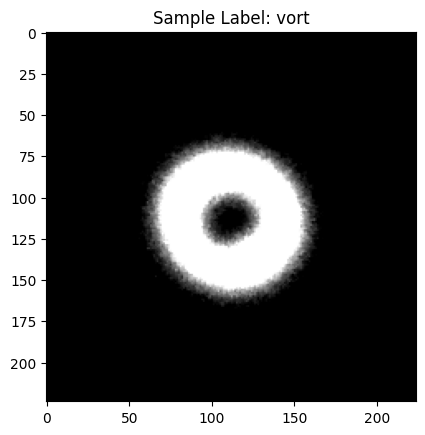

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training...


Epoch 1/15 - Train Loss: 0.7718, Val Loss: 0.4181, Val AUC: 0.9537
✅ New best model saved with Val AUC: 0.9537


Epoch 2/15 - Train Loss: 0.3419, Val Loss: 0.2714, Val AUC: 0.9770
✅ New best model saved with Val AUC: 0.9770


Epoch 3/15 - Train Loss: 0.2668, Val Loss: 0.2300, Val AUC: 0.9837
✅ New best model saved with Val AUC: 0.9837


Epoch 4/15 - Train Loss: 0.2356, Val Loss: 0.2146, Val AUC: 0.9859
✅ New best model saved with Val AUC: 0.9859


Epoch 5/15 - Train Loss: 0.2100, Val Loss: 0.2064, Val AUC: 0.9860
✅ New best model saved with Val AUC: 0.9860


Epoch 6/15 - Train Loss: 0.1945, Val Loss: 0.2009, Val AUC: 0.9874
✅ New best model saved with Val AUC: 0.9874


Epoch 7/15 - Train Loss: 0.1818, Val Loss: 0.1867, Val AUC: 0.9891
✅ New best model saved with Val AUC: 0.9891


Epoch 8/15 - Train Loss: 0.1739, Val Loss: 0.1644, Val AUC: 0.9907
✅ New best model saved with Val AUC: 0.9907


Epoch 9/15 - Train Loss: 0.1632, Val Loss: 0.1612, Val AUC: 0.9906


Epoch 10/15 - Train Loss: 0.1602, Val Loss: 0.1532, Val AUC: 0.9923
✅ New best model saved with Val AUC: 0.9923


Epoch 11/15 - Train Loss: 0.1501, Val Loss: 0.1662, Val AUC: 0.9912


Epoch 12/15 - Train Loss: 0.1466, Val Loss: 0.1262, Val AUC: 0.9942
✅ New best model saved with Val AUC: 0.9942


Epoch 13/15 - Train Loss: 0.1411, Val Loss: 0.1414, Val AUC: 0.9926


Epoch 14/15 - Train Loss: 0.1397, Val Loss: 0.1461, Val AUC: 0.9934


Epoch 15/15 - Train Loss: 0.1325, Val Loss: 0.1325, Val AUC: 0.9938
Training Finished!


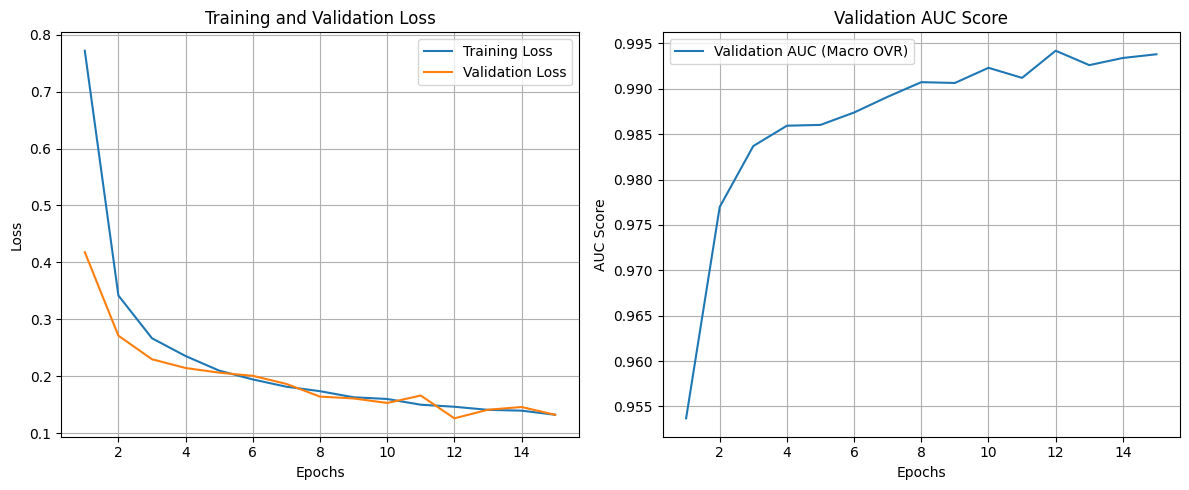


Evaluating on Test Set...


Testing: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]



Test Accuracy: 0.9544
Test ROC AUC (OVR Macro): 0.9943
Test ROC AUC (OVO Macro): 0.9943

Classification Report (Test Set):
              precision    recall  f1-score   support

          no       0.93      0.99      0.96      1250
      sphere       0.98      0.90      0.94      1250
        vort       0.96      0.98      0.97      1250

    accuracy                           0.95      3750
   macro avg       0.96      0.95      0.95      3750
weighted avg       0.96      0.95      0.95      3750



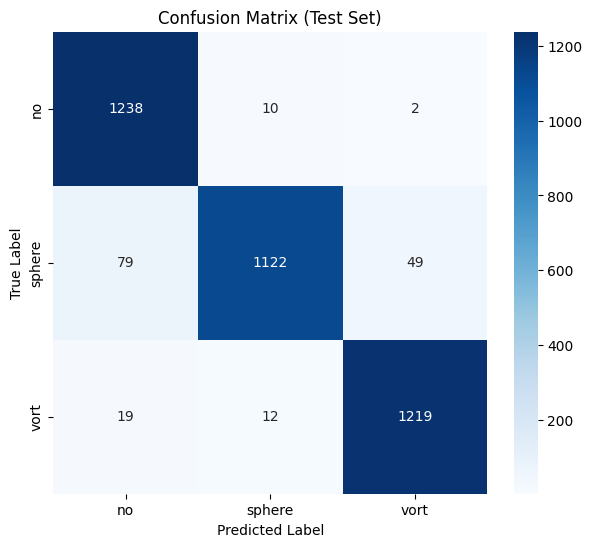

NameError: name 'cycle' is not defined

<Figure size 800x700 with 0 Axes>

In [3]:
# --- Dataset Class ---
class LensDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.classes = ['no', 'sphere', 'vort']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform
        self.samples = []

        for label, cls in enumerate(self.classes):
            cls_dir = os.path.join(self.root_dir, cls)
            if not os.path.isdir(cls_dir):
                print(f"Warning: Directory not found {cls_dir}")
                continue
            files = [f for f in os.listdir(cls_dir) if f.endswith('.npy')]
            for file in files:
                full_path = os.path.join(cls_dir, file)
                self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        try:
            # Load the z-normalized image (shape should be (1, H, W))
            image_np = np.load(file_path)

            # Ensure image is float32
            image_np = image_np.astype(np.float32)

            # Squeeze the first dimension if it's 1 -> (H, W)
            if image_np.shape[0] == 1:
                 image_np = np.squeeze(image_np, axis=0)

            # Convert grayscale (H, W) to PIL Image (required by many torchvision transforms)
            # Need to scale to 0-255 for standard PIL conversion from float
            # Since it's z-normalized, this isn't ideal. Let's handle channels differently.
            # Instead of PIL, let's use tensors directly and repeat channels

            # Convert numpy array to tensor
            image_tensor = torch.from_numpy(image_np)

            # Add channel dimension: (H, W) -> (1, H, W)
            if image_tensor.dim() == 2:
                 image_tensor = image_tensor.unsqueeze(0)

            # Repeat channel to simulate RGB: (1, H, W) -> (3, H, W)
            image_tensor = image_tensor.repeat(3, 1, 1)

            # Apply transformations if any (should work on tensors)
            if self.transform:
                 image_tensor = self.transform(image_tensor)

            # Ensure final tensor shape is (3, H, W)
            # Note: ConvNeXt V2 processor might handle resizing internally,
            # but applying it here ensures consistency if needed.

        except Exception as e:
            print(f"Error loading or processing file {file_path}: {e}")
            # Return a dummy tensor and label or raise error
            # For simplicity, returning None here, handle in DataLoader collation if necessary
            return None, None # Or handle more gracefully

        return image_tensor, label

# --- Transformations ---
# Get image size expected by the model processor
processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)
# --- Corrected Image Size Determination ---
if isinstance(processor.size, dict):
    # Check for common keys, prioritize 'shortest_edge' if present for square inputs
    if "shortest_edge" in processor.size:
        IMG_SIZE = processor.size["shortest_edge"]
    elif "height" in processor.size:
        IMG_SIZE = processor.size["height"] # Fallback if height exists but shortest_edge doesn't
    else:
        # Handle unexpected dictionary structure, maybe default or raise error
        print(f"Warning: 'shortest_edge' or 'height' key not found in processor.size dictionary: {processor.size}. Defaulting to 224.")
        IMG_SIZE = 224
elif isinstance(processor.size, int):
    # If size is just an integer
    IMG_SIZE = processor.size
else:
    # Handle other unexpected types, default or raise error
    print(f"Warning: processor.size has unexpected type: {type(processor.size)}. Defaulting to 224.")
    IMG_SIZE = 224

print(f"Using image size for resizing: {IMG_SIZE}x{IMG_SIZE}")

# Define transforms - applied AFTER channel repetition
# Note: We skip normalization here as the data is already z-normalized per image.
# Standard ImageNet normalization might be better if starting from raw data.
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True), # Resize to match model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=30, scale=(0.9, 1.1), translate=(0.1, 0.1)),
    # Add more augmentations if desired
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True), # Resize to match model input
])

# --- Datasets and DataLoaders ---
train_dataset = LensDataset(root_dir=DATA_ROOT, split="train", transform=train_transform)
val_dataset   = LensDataset(root_dir=DATA_ROOT, split="val", transform=val_test_transform)
test_dataset  = LensDataset(root_dir=DATA_ROOT, split="test", transform=val_test_transform)

# Filter out None samples potentially returned by __getitem__ on error
train_dataset.samples = [s for s in train_dataset.samples if s is not None]
val_dataset.samples = [s for s in val_dataset.samples if s is not None]
test_dataset.samples = [s for s in test_dataset.samples if s is not None]

# Custom collate function to handle potential None values if needed
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor() # Return empty tensors if batch is empty
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print("Dataset sizes:")
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

# Check a sample batch
try:
    images, labels = next(iter(train_loader))
    print("Sample batch - Image shape:", images.shape) # Should be [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
    print("Sample batch - Labels shape:", labels.shape)
    # Plot one image from the batch
    plt.imshow(images[0].permute(1, 2, 0).numpy()) # Convert (C, H, W) to (H, W, C) for plotting
    plt.title(f"Sample Label: {train_dataset.classes[labels[0].item()]}")
    plt.show()
except Exception as e:
    print(f"Error checking dataloader: {e}")

# --- Model Definition ---
model = ConvNextV2ForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True # Important to load weights except for the classifier
)
model.to(DEVICE)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# --- Training Loop ---
train_losses = []
val_losses = []
val_aucs = []
best_val_auc = -1.0

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

    for images, labels in train_loop:
        if images is None or labels is None: continue # Skip bad batches
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits # Get logits from the model output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        train_loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    all_val_labels = []
    all_val_probs = []
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)

    with torch.no_grad():
        for images, labels in val_loop:
            if images is None or labels is None: continue
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())
            val_loop.set_postfix(loss=loss.item())

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    # Calculate Validation AUC
    val_labels_np = np.array(all_val_labels)
    val_probs_np = np.array(all_val_probs)
    try:
        # Ensure there are samples for all classes present in this validation batch run
        if len(np.unique(val_labels_np)) == NUM_CLASSES:
             epoch_val_auc = roc_auc_score(val_labels_np, val_probs_np, multi_class='ovr', average='macro')
        else:
             print(f"Warning: Not all classes present in validation set for epoch {epoch+1}. AUC may be inaccurate.")
             # Calculate based on available classes if needed, or skip/report NaN
             epoch_val_auc = float('nan') # Or calculate only if len > 1?
        val_aucs.append(epoch_val_auc)
    except ValueError as e:
        print(f"Could not compute AUC for epoch {epoch+1}: {e}")
        epoch_val_auc = float('nan') # Handle case where AUC can't be computed
        val_aucs.append(epoch_val_auc)


    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")

    scheduler.step(epoch_val_loss)

    # Save best model based on validation AUC
    if not np.isnan(epoch_val_auc) and epoch_val_auc > best_val_auc:
        best_val_auc = epoch_val_auc
        torch.save(model.state_dict(), "convnextv2_best_model.pth")
        print(f"✅ New best model saved with Val AUC: {best_val_auc:.4f}")

print("Training Finished!")

# --- Plotting Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_aucs, label='Validation AUC (Macro OVR)')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('Validation AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_history_convnextv2.png")
plt.show()


# --- Evaluation on Test Set ---
print("\nEvaluating on Test Set...")
# Load best model
model.load_state_dict(torch.load("convnextv2_best_model.pth"))
model.to(DEVICE)
model.eval()

all_test_labels = []
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        if images is None or labels is None: continue
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(pixel_values=images).logits
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

test_labels_np = np.array(all_test_labels)
test_preds_np = np.array(all_test_preds)
test_probs_np = np.array(all_test_probs)

# Calculate final metrics
test_accuracy = (test_preds_np == test_labels_np).mean()
try:
    # Binarize labels for multiclass ROC AUC calculation
    test_labels_bin = np.eye(NUM_CLASSES)[test_labels_np]
    test_auc_ovr_macro = roc_auc_score(test_labels_bin, test_probs_np, multi_class='ovr', average='macro')
    test_auc_ovo_macro = roc_auc_score(test_labels_np, test_probs_np, multi_class='ovo', average='macro') # Needs labels, not binarized
except ValueError as e:
    print(f"Could not compute test AUC: {e}")
    test_auc_ovr_macro = float('nan')
    test_auc_ovo_macro = float('nan')


print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC (OVR Macro): {test_auc_ovr_macro:.4f}")
print(f"Test ROC AUC (OVO Macro): {test_auc_ovo_macro:.4f}") # ovo might be more stable if classes are imbalanced slightly

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(test_labels_np, test_preds_np, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels_np, test_preds_np)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.savefig("confusion_matrix_convnextv2.png")
plt.show()

# Plot ROC Curve for Test Set
plt.figure(figsize=(8, 7))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(NUM_CLASSES), colors):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {train_dataset.classes[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set - OVR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_test_convnextv2.png")
plt.show()

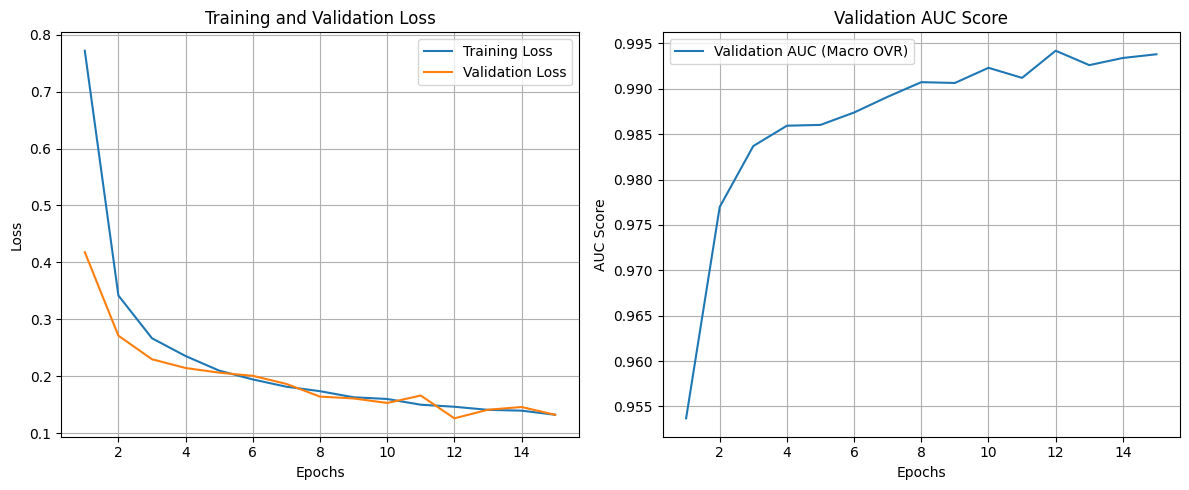


Evaluating on Test Set...


Testing: 100%|██████████| 38/38 [00:10<00:00,  3.47it/s]



Test Accuracy: 0.9544
Test ROC AUC (OVR Macro): 0.9943
Test ROC AUC (OVO Macro): 0.9943

Classification Report (Test Set):
              precision    recall  f1-score   support

          no       0.93      0.99      0.96      1250
      sphere       0.98      0.90      0.94      1250
        vort       0.96      0.98      0.97      1250

    accuracy                           0.95      3750
   macro avg       0.96      0.95      0.95      3750
weighted avg       0.96      0.95      0.95      3750



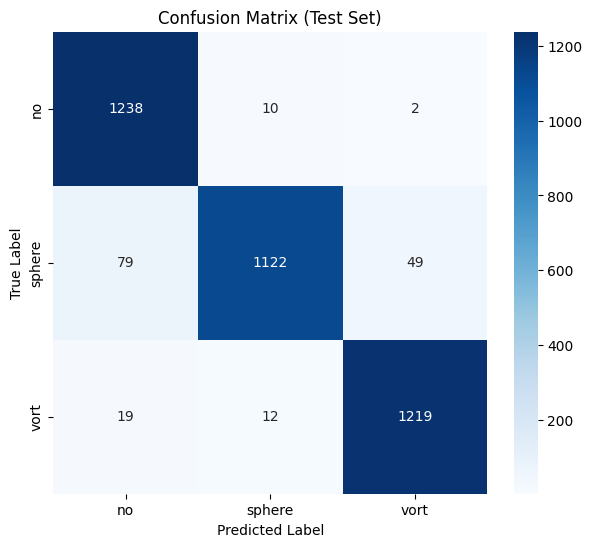

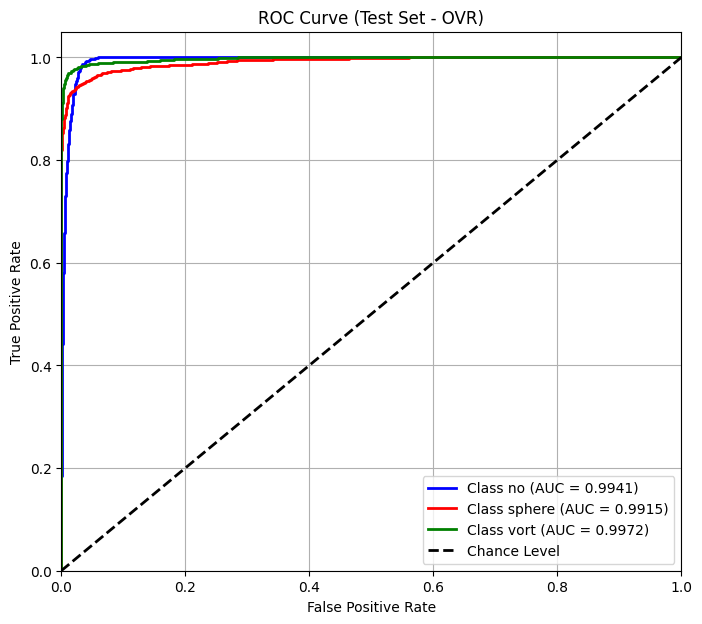

In [9]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_aucs, label='Validation AUC (Macro OVR)')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('Validation AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_history_convnextv2.png")
plt.show()
plt.close()


# --- Evaluation on Test Set ---
print("\nEvaluating on Test Set...")
# Load best model
model.load_state_dict(torch.load("convnextv2_best_model.pth"))
model.to(DEVICE)
model.eval()

all_test_labels = []
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        if images is None or labels is None: continue
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(pixel_values=images).logits
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

test_labels_np = np.array(all_test_labels)
test_preds_np = np.array(all_test_preds)
test_probs_np = np.array(all_test_probs)

# Calculate final metrics
test_accuracy = (test_preds_np == test_labels_np).mean()
try:
    # Binarize labels for multiclass ROC AUC calculation
    test_labels_bin = np.eye(NUM_CLASSES)[test_labels_np]
    test_auc_ovr_macro = roc_auc_score(test_labels_bin, test_probs_np, multi_class='ovr', average='macro')
    test_auc_ovo_macro = roc_auc_score(test_labels_np, test_probs_np, multi_class='ovo', average='macro') # Needs labels, not binarized
except ValueError as e:
    print(f"Could not compute test AUC: {e}")
    test_auc_ovr_macro = float('nan')
    test_auc_ovo_macro = float('nan')


print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC (OVR Macro): {test_auc_ovr_macro:.4f}")
print(f"Test ROC AUC (OVO Macro): {test_auc_ovo_macro:.4f}") # ovo might be more stable if classes are imbalanced slightly

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(test_labels_np, test_preds_np, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels_np, test_preds_np)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.savefig("confusion_matrix_convnextv2.png")
plt.show()
plt.close()

# Plot ROC Curve for Test Set
plt.figure(figsize=(8, 7))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(NUM_CLASSES), colors):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {train_dataset.classes[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set - OVR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve_test_convnextv2.png")
plt.show()